<a href="https://colab.research.google.com/github/gaioguy/EntropicTransferOperators/blob/main/Molecule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entropic transfer operators
## Experiment 3: Alanine dipeptide

cf. [O. Junge, D. Matthes, B. Schmitzer: Entropic transfer operators, preprint, 2022.](https://arxiv.org/abs/?)

We analyse the dynamics of the small biomolecule alanine dipeptide. To this end, we determine almost invariant subsets in position space by computing eigenvectors at a couple of real eigenvalues close to 1 of the entropically regularized transfer operatior on a point cloud given by trajectory data taken from https://markovmodel.github.io/mdshare/ALA2.

## preparations

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
loc = "/content/drive/MyDrive/LagrangianOT/" # needs to be adapted
sys.path.append(loc)
!pip install pykeops[colab] > install.log
!pip install mdshare > install.log

import mdshare
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans
import lib.SinkhornKeops as SinkhornKe
from lib.header_notebook import *
from ipywidgets import IntProgress
from IPython.display import display
%config InlineBackend.figure_format = 'retina'
π = np.pi

Mounted at /content/drive
[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


### load data

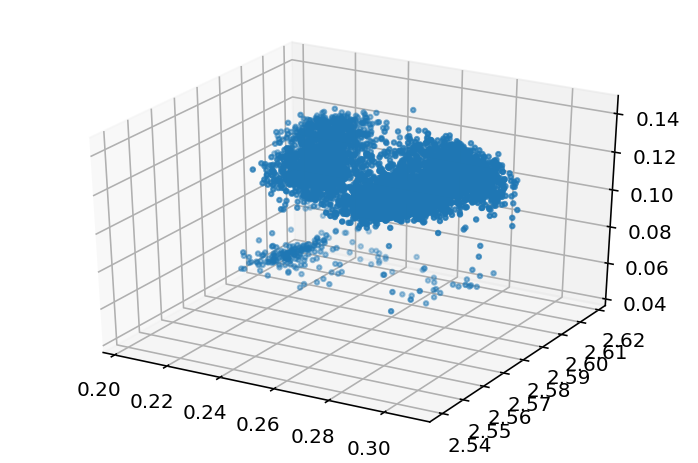

In [37]:
file_positions = mdshare.fetch('alanine-dipeptide-3x250ns-heavy-atom-positions.npz')
data = np.load(local_file_positions)
file_angles = mdshare.fetch('alanine-dipeptide-3x250ns-backbone-dihedrals.npz')
dataAngles = np.load(file_angles)

subsamp = 50 # or 25
dim = 30
lag = 10
X = np.array(data["arr_0"][::subsamp,:dim],order="C",dtype=np.float32)
Y = np.array(data["arr_0"][lag::subsamp,:dim],order="C",dtype=np.float32)
α = dataAngles["arr_0"][::subsamp,:]

ax = plt.axes(projection ="3d")
ax.scatter3D(X[:,3], X[:,4], X[:,5], s=5)

### initialize Sinkhorn solver

In [38]:
N, dim = X.shape
Ny = Y.shape[0]
print(N, Ny)
μX = np.ones(N, dtype=np.float32)
μX = μX/np.sum(μX)
μY = np.ones(Ny, dtype=np.float32)
μY = μY/np.sum(μY)
εInit, ε, errorGoal = 1.0, 1E-5, 0.01
solver = SinkhornKe.TKeopsSinkhornSolverStandard(X, Y, μX, μY, errorGoal, eps=ε, epsInit=εInit)
solver.solve()

5000 5000


0

## compute eigendata for specific ε

In [48]:
ε = 1.0e-2
solver.setRelEpsList(ε)
solver.solve()
Γ = solver.extractCoupling(thresh=1E-16, maxLen=1e8)
Γ.data[:] *= N
eigdat = eigs(Γ, k=20, which='LR')
I = np.logical_and(abs(np.imag(eigdat[0])) < 1e-14, eigdat[0] > 0)
λ = eigdat[0][I]
λ

array([0.9999984 +0.j, 0.9832531 +0.j, 0.859527  +0.j, 0.34388155+0.j,
       0.17188981+0.j, 0.09160227+0.j, 0.07222863+0.j, 0.05840837+0.j,
       0.04421525+0.j], dtype=complex64)

## plot projection of some eigenfunction onto dihedral angles

(5000, 9)


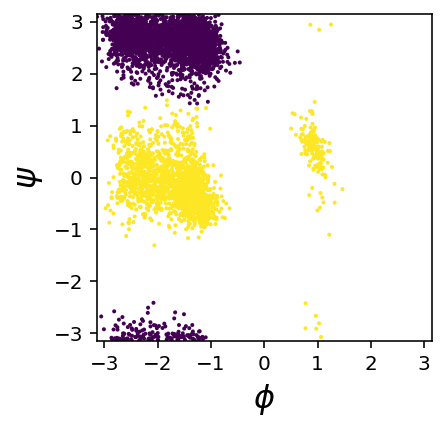

In [42]:
fig = plt.figure(figsize=(3,3))
eigvecs = eigdat[1][:,I]
print(eigvecs.shape)
k = 2  # which eigenvector to plot
v = eigvecs[:,k].real
s = [1 for n in range(len(v))]
plt.scatter(α[:,0],α[:,1], c=np.sign(v), s=s)
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
plt.axis([-π,π,-π,π])
plt.xlabel(r'$\phi$', fontsize=16)
plt.ylabel(r'$\psi$', fontsize=16)
filename = 'eigenvector_'+'%d'%k+'_N='+'%d'%N+'_eps='+'%2.2f'%ε
plt.savefig(loc + 'figures/molecule/' + filename + '.png', dpi=200, bbox_inches = 'tight')
plt.show()

## real spectra of Γ close to 1 in dependence of ε

In [55]:
ε0, ε1, nε, nσ = -1, -6, 200, 10          # ε range, no of εs, no of eigenvalues
εs = np.logspace(ε0, ε1, num = nε)
σs = np.zeros((nε, nσ))
progressbar = IntProgress(min=0, max=nε)
display(progressbar)

for k in np.arange(0, nε):
  solver.setRelEpsList(εs[k])
  solver.solve()
  Γ = solver.extractCoupling(thresh=1E-16, maxLen=1e8)
  Γ.data[:] *= N
  eigdat = eigs(Γ, k=nσ, which='LR')
  I = np.logical_and(abs(np.imag(eigdat[0])) < 1e-14, eigdat[0] > 0)
  σ = eigdat[0][I]
  σs[k,0:np.shape(σ)[0]] = σ.real
  progressbar.value += 1

filename = 'spectra_N='+'%d'%N+'_eps='+'%1.0f'%ε0+'-to-'+'%1.0f'%ε1
np.savez(loc + 'dump/molecule/' + filename, epsilons=εs, eigenvalues=σs)

IntProgress(value=0, max=200)

## plot spectra in dependence of ε

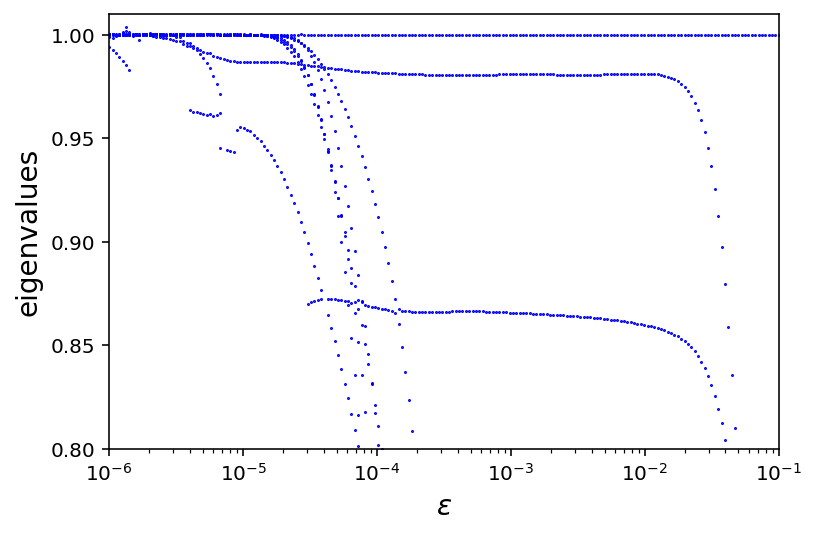

In [56]:
eigdat = np.load(loc + 'dump/molecule/' + filename + '.npz')
εs, σs = eigdat['epsilons'], eigdat['eigenvalues']
plt.plot(εs, σs, '.', markersize=1, color='blue')

plt.axis([10**ε1, 10**ε0, 0.8, 1.01])
ax = plt.gca()
ax.set_xscale('log')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.xlabel(r"$\varepsilon$", fontsize=14)
plt.ylabel("eigenvalues", fontsize=14)
plt.savefig(loc + 'figures/molecule/' + filename + '.pdf')

# kmeans clustering of two dominant eigenfunctions

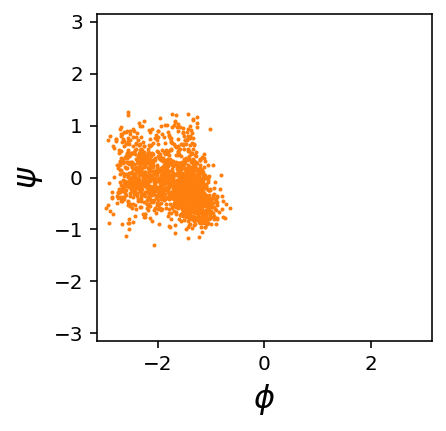

In [54]:
z = eigvecs[:,1:3].real
kmeans = KMeans(n_clusters=3, random_state=0).fit(z)

colors = ['tab:blue','tab:orange','tab:brown']
fig = plt.figure(figsize=(3,3))
k = 1                             # which cluster to plot
I = (kmeans.labels_ == k)
plt.plot(α[I,0],α[I,1],'.', ms=2, c=colors[k])
plt.axis([-π,π,-π,π])
plt.xlabel(r'$\phi$', fontsize=16)
plt.ylabel(r'$\psi$', fontsize=16)
filename = 'cluster_%d'%k + '_N=%d'%N + '_eps=%2.2g'%ε
plt.savefig(loc + 'figures/molecule/' + filename + '.png', dpi=200, bbox_inches = 'tight')
plt.show()